In [1]:
from data_repo import ystock as ys
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
client = ys.ystock()

In [9]:
df = web.DataReader('XGD.TO', data_source = 'yahoo', start='2012-01-01', end = '2020-05-06')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,23.320000,22.850000,22.850000,23.250000,364500.0,22.253675
2012-01-04,23.540001,23.160000,23.219999,23.250000,273100.0,22.253675
2012-01-05,23.570000,23.049999,23.190001,23.450001,281400.0,22.445105
2012-01-06,23.690001,23.370001,23.629999,23.410000,1781600.0,22.406820
2012-01-09,23.629999,23.370001,23.580000,23.450001,293600.0,22.445105
...,...,...,...,...,...,...
2020-04-30,21.320000,20.370001,20.980000,20.430000,1702500.0,20.430000
2020-05-01,21.360001,19.990000,20.100000,21.330000,1870200.0,21.330000
2020-05-04,21.980000,21.500000,21.690001,21.840000,1085900.0,21.840000


In [10]:
# get the number of rows and columns 
df.shape

(2095, 6)

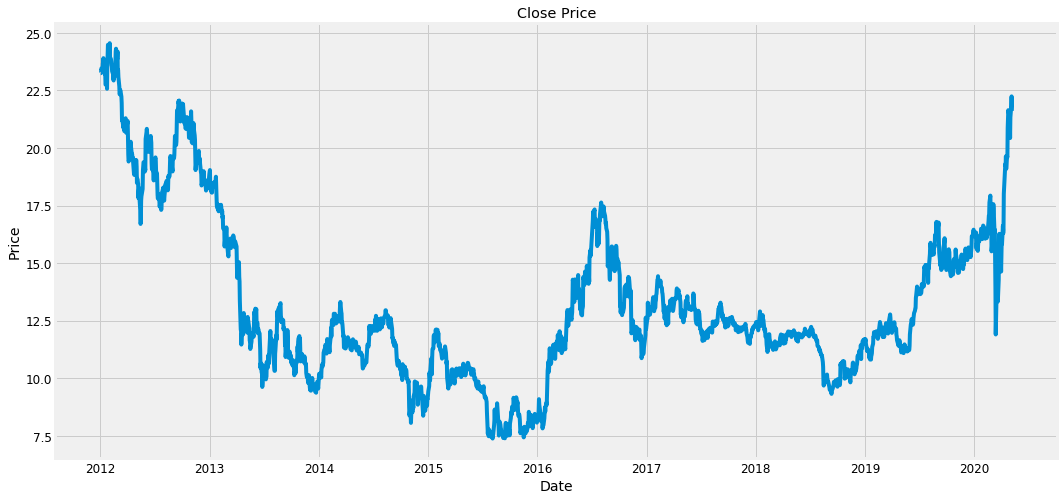

In [11]:
plt.figure(figsize=(16,8))
plt.title('Close Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [13]:
# create a new dataframe with only the close column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)

print(training_data_len)

1676


In [14]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.92428659]
 [0.92428659]
 [0.93593486]
 ...
 [0.84216661]
 [0.86546304]
 [0.82877118]]


In [20]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
# take 60days values in to the train set
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])


In [21]:
x_train, y_train = np.array(x_train), np.array(y_train)
# reshape the data
train_shape = x_train.shape
x_train = np.reshape(x_train, (train_shape[0], train_shape[1], 1))
x_train.shape

(1616, 60, 1)

In [23]:
# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(train_shape[1], 1 )))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
model.compile(optimizer='adam',loss = 'mean_squared_error')


In [25]:
# train the model
model.fit(x_train, y_train, batch_size = 1, epochs= 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1616 samples
1616/1616 [==============================] - 290s 179ms/sample - loss: 0.0024


In [27]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [28]:
x_test = np.array(x_test)

In [29]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [32]:
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

0.5619332670880958

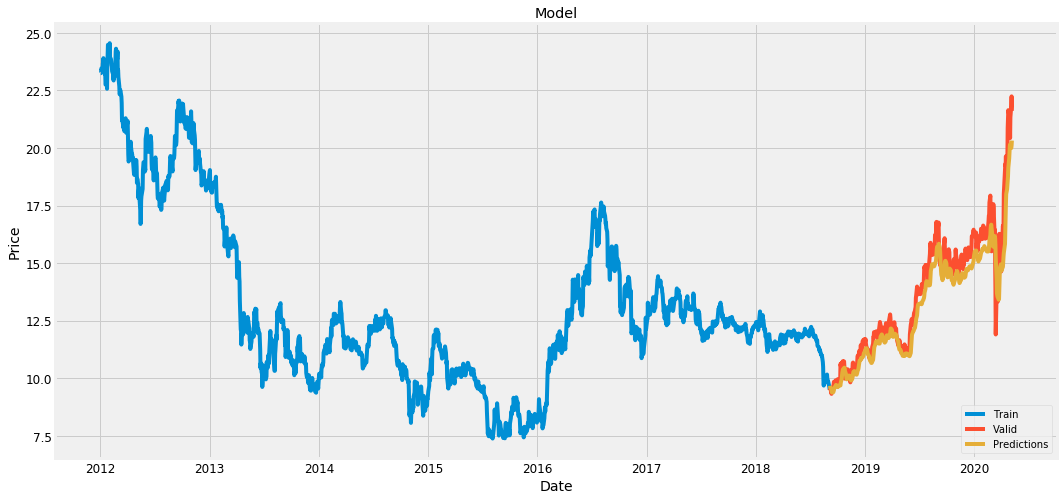

In [33]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train','Valid', 'Predictions'], loc='lower right')
plt.show()

In [34]:
valid

,Close,predictions
Date,,
2018-09-06,9.480000,9.672490
2018-09-07,9.540000,9.584207
2018-09-10,9.400000,9.520444
2018-09-11,9.320000,9.457994
2018-09-12,9.550000,9.394752
...,...,...
2020-04-30,20.430000,20.154480
2020-05-01,21.330000,20.028187
2020-05-04,21.840000,19.997501


In [37]:
quote = web.DataReader('XGD.TO', data_source = 'yahoo', start='2012-01-01', end = '2020-05-06')
new_df = quote.filter(['Close'])
# get the last 60 days and convert to array
last_60 = new_df[-60:].values
last_60_scaled = scaler.transform(last_60)
pred_test = []
pred_test.append(last_60_scaled)

pred_test = np.array(pred_test)
pred_test = np.reshape(pred_test, (pred_test.shape[0],pred_test.shape[1], 1))

pred_price = model.predict(pred_test)
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[[20.432566]]


In [ ]:
quote2 = web.DataReader('XGD.TO', data_source = 'yahoo', start='2012-01-01', end = '2020-05-06')